In [13]:
from dataset.dataset import * 
from model.gru import GRU
from model.lstm import LSTM
from utils.loss import max_sharpe 
from utils.optimizer import SAM 
from utils.utils import save_model, remove_prefix, load_model
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle

In [14]:
dic = ["aapl", "pdd", "tsla", "meta", "jpm", "amd", "ngg", "biib", "ba", "ryaay"]
in_path="data/stocks/"
out_path="data/"
for i, ticker in enumerate(dic):
    stock = in_path + f"{ticker}.csv"
    stock_df = pd.read_csv(stock, index_col="Date")[["Adj Close"]]
    if i == 0:
        return_df = stock_df.pct_change()
        return_df.columns = [ticker]
    else:
        return_df[ticker] = stock_df.pct_change()
return_df = return_df.dropna()
return_df

,aapl,pdd,tsla,meta,jpm,amd,ngg,biib,ba,ryaay
Date,,,,,,,,,,
2022-01-04,-0.012692,-0.111943,-0.041833,-0.005937,0.037910,-0.038738,0.001936,-0.009871,0.027759,0.024521
2022-01-05,-0.026600,-0.025893,-0.053471,-0.036728,-0.018282,-0.057264,-0.009662,-0.010177,-0.002621,0.011004
2022-01-06,-0.016693,0.074181,-0.021523,0.025573,0.010624,0.000588,-0.010035,-0.008233,-0.008119,0.012245
2022-01-07,0.000988,0.072319,-0.035447,-0.002015,0.009908,-0.031050,0.008166,-0.019806,0.019684,0.039337
2022-01-10,0.000116,0.019499,0.030342,-0.011212,0.000957,0.000000,-0.000978,0.011651,-0.028724,-0.000172
...,...,...,...,...,...,...,...,...,...,...
2022-10-24,0.014803,-0.246057,-0.014876,-0.002231,0.001227,-0.002040,0.021022,0.026156,0.005166,0.000315
2022-10-25,0.019338,0.069051,0.052876,0.060052,0.002615,0.047189,0.033288,-0.003860,0.032383,0.028535
2022-10-26,-0.019627,0.116979,0.009981,-0.055923,0.011491,-0.028307,0.001676,0.025113,-0.087692,0.031116


In [110]:
return_df_train_valid = return_df[return_df.index < '2022-10-01']
x_tr, y_tr, x_te, y_te, times_tr, times_te = data_split(
        return_df_train_valid,
        45,
        15,
        '2022-08-01',
        10,
    )

path = "data/"
with open(path + "date.pkl", "wb") as f:
    pickle.dump(times_te, f)
with open(path + "dataset.pkl", "wb") as f:
    pickle.dump([x_tr, y_tr, x_te, y_te], f)

# Train

In [111]:
class GRU_CFG:
    n_layers = 2
    n_stocks = 10 
    hidden_dim = 256 
    bidirectional = False
    dropout = 0.2
    lb = 0.
    ub = 0.3

class LSTM_CFG:
    n_layers = 2
    n_stocks = 10 
    hidden_dim = 256 
    bidirectional = False
    dropout = 0.2
    lb = 0.03
    ub = 0.3

In [112]:
### dataset 
with open("data/dataset.pkl", "rb") as f:
    train_x_raw, train_y_raw, test_x_raw, test_y_raw = pickle.load(f)

with open("data/date.pkl", "rb") as f:
    test_date = pickle.load(f)
train_x_raw = train_x_raw
train_y_raw = train_y_raw
test_x_raw = test_x_raw
test_y_raw = test_y_raw
test_date = test_date

# convert to tensor
train_x = torch.from_numpy(train_x_raw.astype("float32"))
train_y = torch.from_numpy(train_y_raw.astype("float32"))
test_x = torch.from_numpy(test_x_raw.astype("float32"))
test_y = torch.from_numpy(test_y_raw.astype("float32"))

# train dataset 
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

# train dataloder
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= 16, shuffle = False, drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 4, shuffle = False, drop_last = False)

In [113]:
### models
# parameters
LEN_TRAIN = train_x.shape[1]
LEN_PRED = test_x.shape[1]
N_STOCK = 10
LR = 0.1
MOMENTUM = 0.9 
N_EPOCH = 500
EARLY_STOP = 20

# model 
# gru_cfg = GRU_CFG()
# model = GRU(gru_cfg)
# model.cuda()

lstm_cfg = LSTM_CFG()
model = LSTM(lstm_cfg)
model.cuda()

# criterion and optimizer
base_optimizer = torch.optim.SGD
optimizer = SAM(
    model.parameters(), base_optimizer, lr = LR, momentum = MOMENTUM 
)

criterion = max_sharpe 

In [114]:
# train
train_loss = []
valid_loss = []

early_stop_cnt = 0
for epoch in range(N_EPOCH):
#     if epoch != 0 and epoch % 5 == 0:     
#         print("Epoch {}/{}, training_loss:{}, testing_loss:{}".format(epoch + 1, N_EPOCH, train_loss[-1], valid_loss[-1]))
#         print("-" * 10)
        
    for mode in ["train",'valid']:
        if mode == 'train':
            model.train()
            dataloader = train_loader 
        else:
            model.eval()
            dataloader = test_loader
        running_loss = 0. 
        for idx, batch in enumerate(dataloader):
            x, y = batch 
            x = x.to("cuda")
            y = y.to("cuda")
            optimizer.zero_grad()
            with torch.set_grad_enabled(mode == "train"):
                out = model(x)
                loss = criterion(y, out)
                if mode == 'train':
                    loss.backward()
                    optimizer.first_step(zero_grad = True)
                    criterion(y, model(x)).backward()
                    optimizer.second_step(zero_grad = True) 
            running_loss += loss.item() / len(dataloader)
        if mode == 'train':
            train_loss.append(running_loss)
        else:
            valid_loss.append(running_loss)
            if running_loss <= min(valid_loss):
                save_model(model, "result", "hb")
                print(f"Improved! at {epoch + 1} epochs, with {running_loss}")
                early_stop_cnt = 0
            else:
                early_stop_cnt += 1
    if early_stop_cnt == EARLY_STOP:
        break

Improved! at 1 epochs, with 0.15134620678145438
Improved! at 2 epochs, with 0.14935199689352885
Improved! at 3 epochs, with 0.14662016037618741
Improved! at 4 epochs, with 0.1433129960205406
Improved! at 5 epochs, with 0.13949742092518136
Improved! at 6 epochs, with 0.13512091658776626
Improved! at 7 epochs, with 0.13015406514750794
Improved! at 8 epochs, with 0.12446227291366085
Improved! at 9 epochs, with 0.11781449493719265
Improved! at 10 epochs, with 0.10995278629707173
Improved! at 11 epochs, with 0.10049555753357708
Improved! at 12 epochs, with 0.08889591600745916
Improved! at 13 epochs, with 0.07432276109466329
Improved! at 14 epochs, with 0.05568392184795812
Improved! at 15 epochs, with 0.03152520826552063
Improved! at 16 epochs, with 0.00016971235163509846
Improved! at 17 epochs, with -0.0015978423180058599
Improved! at 18 epochs, with -0.003777960198931396
Improved! at 19 epochs, with -0.006541486247442663
Improved! at 20 epochs, with -0.010156252072192729
Improved! at 21 ep

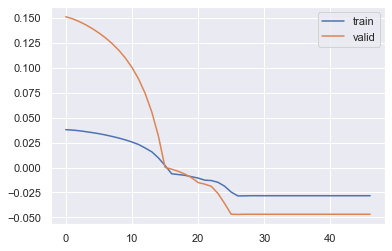

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.plot(train_loss, label="train")
plt.plot(valid_loss, label="valid")
plt.legend(loc="upper right")
plt.savefig('loss')
plt.show()

In [128]:
# Simulation

In [135]:
def generate_random(k):
    for time in range(k):
        randomPortfolio = [10000]
        for i in range(0, test_x.shape[0], 10):
            randomWeights = np.random.dirichlet(np.ones(10))
            x = test_x[i][np.newaxis, :, :]
            # m_rtn = np.sum(test_y_raw[i], axis=0)
            
            randomPortfolio.append(
                randomPortfolio[-1] * (np.dot(randomWeights, np.cumprod(test_y_raw[i] + 1, axis = 0)[-1]))
            )
        if time == 1:
            plt.plot(randomPortfolio, color = 'green', label = 'Random')
        else:
            plt.plot(randomPortfolio, color = 'green')
    

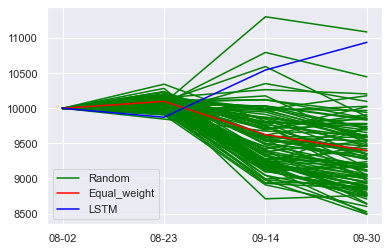

In [151]:
model = load_model(model, "result/best_model_weight_hb.pt", use_cuda=True)
myPortfolio, equalPortfolio = [10000], [10000]
EWPWeights = np.ones(N_STOCK) / N_STOCK
myWeights = []
for i in range(0, test_x.shape[0], 10):
    x = test_x[i][np.newaxis, :, :]
    out = model(x.float().cuda())[0]
    myWeights.append(out.detach().cpu().numpy())
    myPortfolio.append(
        myPortfolio[-1] * np.dot(out.detach().cpu().numpy(), np.cumprod(test_y_raw[i] + 1, axis = 0)[-1])
    )
    equalPortfolio.append(
        equalPortfolio[-1] * (np.dot(EWPWeights, np.cumprod(test_y_raw[i] + 1, axis = 0)[-1]))
    )
generate_random(100)
xticks = ['08-02', '08-23','09-14','09-30']
plt.plot(xticks,equalPortfolio, color = 'red',label = 'Equal_weight')
plt.plot(xticks,myPortfolio,color = 'blue', label = 'LSTM')
plt.legend(loc="lower left")
plt.savefig('return')

In [ ]:
# testing

In [60]:
np.logical_and('2022-08-01' <= return_df.index, return_df.index < '2022-10-01')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [132]:
return_df[174:174 + 16]

,aapl,pdd,tsla,meta,jpm,amd,ngg,biib,ba,ryaay
Date,,,,,,,,,,
2022-09-14,0.009555,0.030227,0.035874,-0.010840,-0.002320,0.005452,-0.011855,0.000981,0.013237,-0.049903
2022-09-15,-0.018930,-0.020467,0.003767,-0.012676,0.015071,-0.010200,-0.029993,0.012787,0.003484,0.013822
2022-09-16,-0.010960,-0.040473,-0.001317,-0.021799,-0.006702,-0.001957,0.002340,0.007450,-0.036654,-0.023967
2022-09-19,0.025083,0.001827,0.018856,0.011826,0.009224,0.003398,0.000834,0.004802,0.004089,0.021761
2022-09-20,0.015665,0.004712,-0.001100,-0.013039,-0.019719,-0.019799,-0.017827,-0.024180,0.007316,-0.026047
2022-09-21,-0.020268,-0.054614,-0.025686,-0.027175,-0.028835,-0.010233,-0.003223,-0.023800,-0.018158,-0.029994
2022-09-22,-0.006375,0.015522,-0.040592,0.004926,-0.011379,-0.066864,-0.001702,0.006421,-0.031963,-0.019802
2022-09-23,-0.015124,-0.053735,-0.045948,-0.016874,-0.018613,-0.022158,-0.039891,-0.014156,-0.053709,-0.028749
2022-09-26,0.002260,0.010158,0.002470,-0.028773,-0.021532,-0.024426,-0.049361,-0.010264,-0.029864,-0.031840


In [56]:
dic = ["aapl", "pdd", "tsla", "meta", "jpm", "amd", "ngg", "biib", "ba", "ryaay"]
in_path="data/stocks/"
out_path="data/"
for i, ticker in enumerate(dic):
    stock = in_path + f"{ticker}.csv"
    stock_df = pd.read_csv(stock, index_col="Date")[["Adj Close"]]
    if i == 0:
        return_df = stock_df.pct_change()
        return_df.columns = [ticker]
    else:
        return_df[ticker] = stock_df.pct_change()
return_df = return_df.dropna()
return_df

,aapl,pdd,tsla,meta,jpm,amd,ngg,biib,ba,ryaay
Date,,,,,,,,,,
2022-01-04,-0.012692,-0.111943,-0.041833,-0.005937,0.037910,-0.038738,0.001936,-0.009871,0.027759,0.024521
2022-01-05,-0.026600,-0.025893,-0.053471,-0.036728,-0.018282,-0.057264,-0.009662,-0.010177,-0.002621,0.011004
2022-01-06,-0.016693,0.074181,-0.021523,0.025573,0.010624,0.000588,-0.010035,-0.008233,-0.008119,0.012245
2022-01-07,0.000988,0.072319,-0.035447,-0.002015,0.009908,-0.031050,0.008166,-0.019806,0.019684,0.039337
2022-01-10,0.000116,0.019499,0.030342,-0.011212,0.000957,0.000000,-0.000978,0.011651,-0.028724,-0.000172
...,...,...,...,...,...,...,...,...,...,...
2022-10-24,0.014803,-0.246057,-0.014876,-0.002231,0.001227,-0.002040,0.021022,0.026156,0.005166,0.000315
2022-10-25,0.019338,0.069051,0.052876,0.060052,0.002615,0.047189,0.033288,-0.003860,0.032383,0.028535
2022-10-26,-0.019627,0.116979,0.009981,-0.055923,0.011491,-0.028307,0.001676,0.025113,-0.087692,0.031116


In [123]:
test_data = return_df[187 - 30:187].to_numpy()
x_test = torch.tensor(test_data)
x_test = x_test.unsqueeze(0)
out = model(x_test.float().cuda())[0]

In [124]:
y_test = return_df[187:]
y_test

,aapl,pdd,tsla,meta,jpm,amd,ngg,biib,ba,ryaay
Date,,,,,,,,,,
2022-10-03,0.030753,0.001119,-0.086145,0.021595,0.030909,0.043403,0.026004,-0.010112,0.041047,0.019000
2022-10-04,0.025623,0.060974,0.029043,0.012048,0.046784,0.027076,0.018725,0.011918,0.059183,0.068201
2022-10-05,0.002053,-0.004513,-0.034598,-0.009267,-0.012347,0.000589,-0.025065,-0.021537,-0.010486,-0.016512
2022-10-06,-0.006626,-0.013752,-0.011129,0.000648,-0.020382,-0.001325,-0.032946,0.002178,0.000681,-0.015830
2022-10-07,-0.036719,-0.026050,-0.063243,-0.040411,-0.019974,-0.138688,-0.008468,-0.016663,-0.018230,-0.050690
2022-10-10,0.002356,-0.083386,-0.000493,0.002548,-0.009341,-0.010780,-0.017478,-0.012059,0.016257,0.001198
2022-10-11,-0.010255,-0.043769,-0.028974,-0.039241,-0.028860,-0.003114,-0.016778,-0.002787,-0.002502,-0.018632
2022-10-12,-0.004605,0.004129,0.003418,-0.008091,0.016183,0.003817,-0.028372,-0.001574,-0.008741,-0.009058
2022-10-13,0.033613,-0.010189,0.020622,0.021882,0.055593,0.018842,0.042954,0.064138,0.015182,0.050448


In [152]:
def generate_random(k):
    for time in range(k):
        randomPortfolio = [10000]
        randomWeights = np.random.dirichlet(np.ones(10))
        randomPortfolio.append(randomPortfolio[-1] * (np.dot(randomWeights, np.cumprod(y_test.to_numpy() + 1, axis = 0)[-1])))
        if time == 0:
            plt.plot(randomPortfolio, color = 'green', label = 'Random')
        else:
            plt.plot(randomPortfolio, color = 'green')

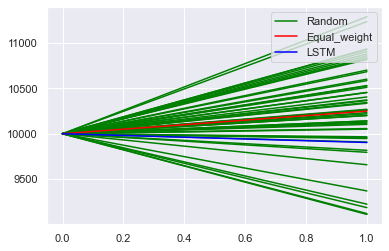

In [153]:
# model = load_model(model, "result/best_model_weight_hb.pt", use_cuda=True)
myPortfolio, equalPortfolio = [10000], [10000]
EWPWeights = np.ones(N_STOCK) / N_STOCK
myPortfolio.append(
    myPortfolio[-1] * np.dot(out.detach().cpu().numpy(), np.cumprod(y_test.to_numpy() + 1, axis = 0)[-1])
)
equalPortfolio.append(
    equalPortfolio[-1] * (np.dot(EWPWeights, np.cumprod(y_test.to_numpy() + 1, axis = 0)[-1]))
)
generate_random(50)
plt.plot(equalPortfolio, color = 'red',label = 'Equal_weight')
plt.plot(myPortfolio,color = 'blue', label = 'LSTM')
plt.legend(loc="upper right")

In [154]:
myPortfolio

[10000, 9903.464639011348]

In [196]:
class LSTM(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.n_layers = config.n_layers
    self.hidden_dim = config.hidden_dim
    self.lb = config.lb 
    self.ub = config.ub 
    self.lstm = nn.LSTM(
        config.n_stocks, config.hidden_dim, num_layers = config.n_layers, batch_first = True, bidirectional = config.bidirectional
    )
    self.dropout = nn.Dropout(config.dropout)
    self.scale = 2 if config.bidirectional else 1 
    self.fc = nn.Linear(config.hidden_dim * self.scale, config.n_stocks)
    self.swish = nn.SiLU() 
  
  def forward(self, x):
      x, _ = self.lstm(x)
      h_t = x[:, -1, :]
      logit = self.fc(self.dropout(h_t))
      logit = self.swish(logit)
      logit = F.softmax(logit, dim=-1)
      logit = torch.stack([self.rebalance(batch, self.lb, self.ub) for batch in logit])
      return logit
    
  def rebalance(self, weight, lb, ub):
    old = weight
    weight_clamped = torch.clamp(old, lb, ub)
    while True:
        leftover = (old - weight_clamped).sum().item()
        nominees = weight_clamped[torch.where(weight_clamped != ub)[0]]
        gift = leftover * (nominees / nominees.sum())
        weight_clamped[torch.where(weight_clamped != ub)[0]] += gift
        old = weight_clamped
        if len(torch.where(weight_clamped > ub)[0]) == 0:
            break
        else:
            weight_clamped = torch.clamp(old, lb, ub)
    return weight_clamped

In [195]:
import torch.nn.functional as F
model = LSTM(lstm_cfg)
model.cuda()
x = torch.randn((1,10,10))
x = x.to("cuda")
model(x)

tensor([[0.0990, 0.0993, 0.1009, 0.1023, 0.1002, 0.1007, 0.0988, 0.0999, 0.0988,
         0.1001]], device='cuda:0', grad_fn=<StackBackward0>)

In [12]:
  def rebalance(self, weight, lb, ub):
    old = weight
    weight_clamped = torch.clamp(old, lb, ub)
    while True:
        leftover = (old - weight_clamped).sum().item()
        nominees = weight_clamped[torch.where(weight_clamped != ub)[0]]
        gift = leftover * (nominees / nominees.sum())
        weight_clamped[torch.where(weight_clamped != ub)[0]] += gift
        old = weight_clamped
        if len(torch.where(weight_clamped > ub)[0]) == 0:
            break
        else:
            weight_clamped = torch.clamp(old, lb, ub)
    return weight_clamped
import torch
old = torch.tensor([0.1,0.1,0.8])
weight_clamped = torch.clamp(old, 0, 0.5)
leftover = (old - weight_clamped).sum().item()
torch.where(weight_clamped != 0.5)[0]

tensor([0, 1])